# Performance evaluation of GGRBF using Wilson editing for noise removal
---------------

*Importing necessary packages*

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef
from sklearn.preprocessing import MinMaxScaler
import core.Gabriel_Graph as GG
from core.RBF import RBF
from core.utils import (
    two_classes_scatter,
    wilson_editing,
    plot_decision_surface,
    GGRBF_K_Fold_Performance,
    GGRBF_LOOCV_Accuracy,
    make_gaussian
)

## 1. Two noisy bivariate gaussians
----------

*Generating data*

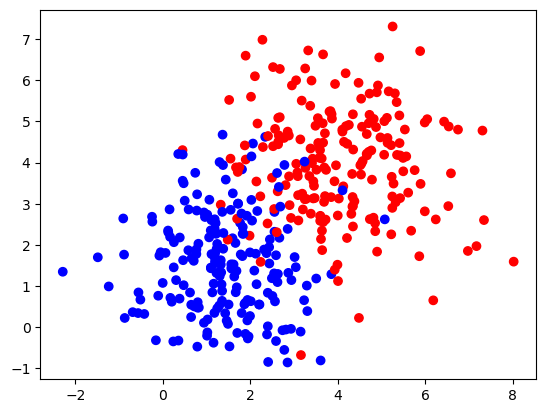

In [14]:
X, y = make_gaussian(200, (1.5,1.5), 1.2, 200, (4,4), 1.4)
X = pd.DataFrame(X)
two_classes_scatter(X, y)

*Noise removal visualization using Wilson editing*

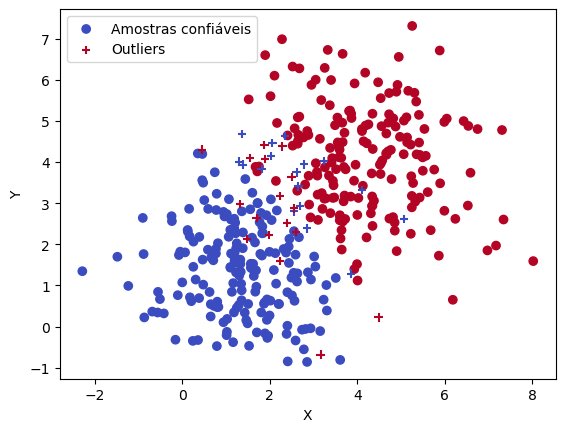

In [15]:
wilson_editing(X, y, k=3, plot=True)

*Data splitting*

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

*Graph building*

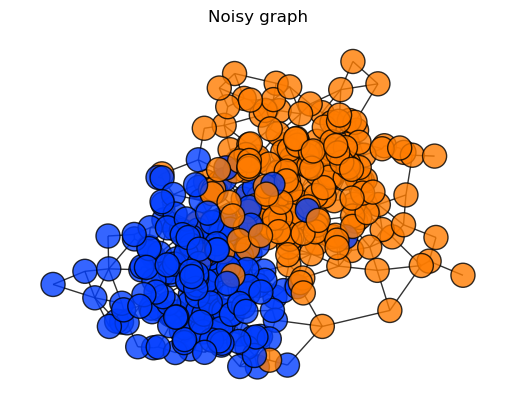

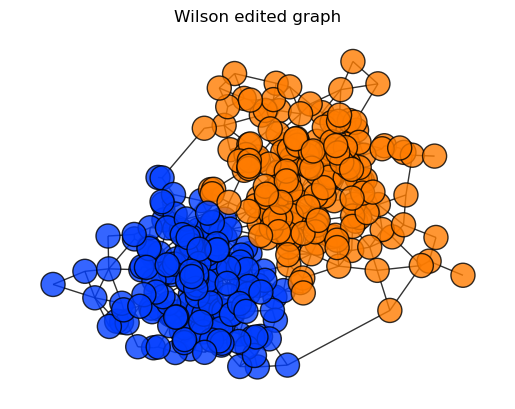

In [17]:
noisy_graph = GG.Gabriel_Graph(X, y)
noisy_graph.build(wilson_editing=False)
plt.title("Noisy graph")
noisy_graph.plot(label=False)

graph = GG.Gabriel_Graph(X, y)
graph.build(wilson_editing=True, k=3)
plt.title("Wilson edited graph")
graph.plot(label=False)


*Calculating and visualizing the centers (SSV)*

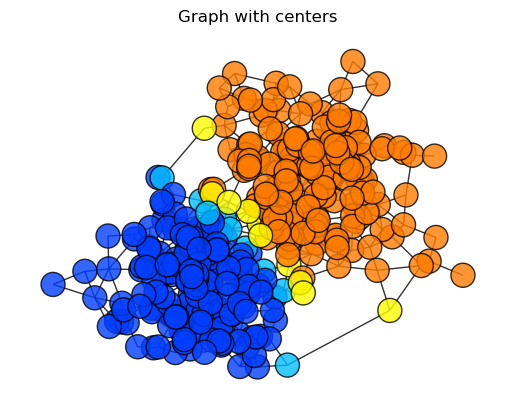

In [18]:
centers = graph.calculate_centers()
plt.title("Graph with centers")
graph.plot(label=False, show_centers=True)

*Using the graph to predict classes via a RBF (Radial Basis Function) network.*

In [19]:
rbf_model = RBF()
rbf_model.fit_model(X_train, y_train, centers, 1, classification=True)

# y_test must be in a {+1, -1} range for comparing it to the predictions
y_test = 2*(y_test)-1

y_hat = rbf_model.predict(X_test, classification=True)

*Evaluating the performance of the model using accuracy, AUC and MMC*

In [20]:
acc = accuracy_score(y_test, y_hat)
auc = roc_auc_score(y_test, y_hat)
mmc = matthews_corrcoef(y_test, y_hat)
print(f"Accuracy: {acc*100:.2f}%\nAUC: {auc:.2f}\nMMC: {mmc:.2f}")

Accuracy: 92.50%
AUC: 0.92
MMC: 0.85


*Visualizing the decision surface*

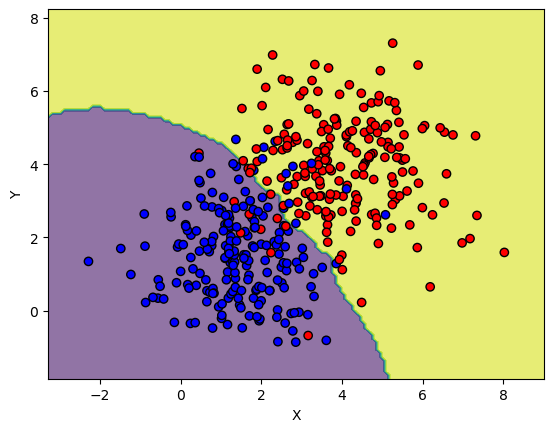

In [21]:
plot_decision_surface(X, y, rbf_model)

## 2. Breast Cancer dataset

*Loading dataset*

In [22]:
dataset_path = './datasets/breast_cancer.csv'
df = pd.read_csv(dataset_path)

*Setting X and y values*

In [23]:
df.head()
index_list = df.iloc[:,0]
X = df.iloc[:,2:30]
y = df.iloc[:,1]
y = 1 * (y == "M")

*Scaling data using MinMax approach*

In [24]:
minmax = MinMaxScaler()
minmax.fit(X)
X_sc = pd.DataFrame(minmax.transform(X))

*Counting outliers*

In [25]:
Xp, yp, X_otl, y_otl, has_otl = wilson_editing(X_sc, y, k=100)
print(f"Outliers removed: {len(X_otl)}")

Outliers removed: 28


*Data splitting*

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sc, y, test_size=0.2, random_state=42
)

*Building the graph*

In [27]:
graph = GG.Gabriel_Graph(X_train, y_train)
graph.build(wilson_editing=True)

*Training a RBF network for classification*

In [28]:
centers = graph.calculate_centers()
rbf_model = RBF()
rbf_model.fit_model(X_train, y_train, centers, 1, classification=True)
y_hat = rbf_model.predict(X_test, classification=True)
y_test = 2*(y_test==1)-1

*Model evaluation*

In [30]:
acc = accuracy_score(y_test, y_hat)
auc = roc_auc_score(y_test, y_hat)
mmc = matthews_corrcoef(y_test, y_hat)

print(f"Accuracy: {acc:.2f}")
print(f"AUC: {auc:.2f}")
print(f"MMC: {mmc:.2f}")

Accuracy: 0.97
AUC: 0.97
MMC: 0.94


### Using cross validation techniques: K-FOLD with 10 folds

Obs.: Data is scaled with MinMaxScaler

#### No Wilson editing

In [31]:
y_p1_n1 = 2*(y==1)-1
mean, sd = GGRBF_K_Fold_Performance(X_sc, y_p1_n1, K_kfold=10, wilson_editing=False, perf_metric='auc')
print(f"AUC: {mean:.2f} +- {sd:.2f}")

AUC: 0.97 +- 0.03


#### Wilson editing with k=1

In [32]:
y_p1_n1 = 2*(y==1)-1
mean, sd = GGRBF_K_Fold_Performance(X_sc, y_p1_n1, K_kfold=10, wilson_editing=True, K_wilson=1, perf_metric='auc')
print(f"AUC: {mean:.2f} +- {sd:.2f}")

AUC: 0.97 +- 0.02


#### Wilson editing with k=3

In [33]:
y_p1_n1 = 2*(y==1)-1
mean, sd = GGRBF_K_Fold_Performance(X_sc, y_p1_n1, K_kfold=10, wilson_editing=True, K_wilson=3, perf_metric='auc')
print(f"AUC: {mean:.2f} +- {sd:.2f}")

AUC: 0.97 +- 0.02
